2. Gợi ý biến vi mô
Nếu bạn có thể thu thập thêm dữ liệu từ báo cáo tài chính của VCB, hoặc từ nguồn VNStock, thì nên thêm:
EPS (Earnings per Share) — lợi nhuận mỗi cổ phiếu.
P/E (Price/Earnings ratio) — mức định giá thị trường.
ROA, ROE — khả năng sinh lợi của tài sản và vốn chủ.
NIM (Net Interest Margin) — chênh lệch lãi suất cho vay – huy động.
Tăng trưởng tín dụng (Loan growth) — cho thấy sức mở rộng hoạt động cho vay.

1. Vix mo:
Chính sách tiền tệ (lãi suất tái chiết khấu, lãi suất cho vay, lãi suất huy động).
Thanh khoản hệ thống (tăng trưởng M2, tỷ lệ dự trữ bắt buộc).
Tỷ giá USD/VND (ảnh hưởng đến hoạt động xuất nhập khẩu, dự trữ ngoại hối).
Chỉ số VNIndex hoặc ngành ngân hàng (đại diện cho tâm lý thị trường chung).
Lạm phát (CPI) và tăng trưởng GDP (ảnh hưởng đến sức mua và tín dụng).

yeu to anh huong:
1. gia lich su
2. kinh te vi mo, vi mo
3. chinh sach nha nuoc
4. chinh sach cong ty

# **0. Setup**

## 0.1. Library and Environment

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

np.random.seed(42)
pd.set_option("display.max_columns", None)

FIG_DIR = "fig"

## 0.2. Data Loading

In [152]:
data = yfinance.download(
    tickers = "^SP500-40",
    start = "1900-01-01",
    end = "2025-01-01",
    interval = "1wk"
)
data.columns = data.columns.get_level_values(0)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.reset_index(inplace=True)
data.columns.name = None
data['Date'] = pd.to_datetime(data['Date'])

/tmp/ipykernel_639723/2307489751.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


# **1. EDA**

## 1.1. Data Summary

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653 entries, 0 to 1652
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1653 non-null   datetime64[ns]
 1   Open    1653 non-null   float64       
 2   High    1653 non-null   float64       
 3   Low     1653 non-null   float64       
 4   Close   1653 non-null   float64       
 5   Volume  1653 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 77.6 KB


In [157]:
data.describe()

,Date,Open,High,Low,Close,Volume
count,1653,1653.000000,1653.000000,1653.000000,1653.000000,1.653000e+03
mean,2009-03-02 00:00:00,344.350146,350.719135,337.683243,344.705971,3.111020e+08
min,1993-05-03 00:00:00,81.739998,99.110001,78.470001,81.739998,0.000000e+00
25%,2001-04-02 00:00:00,221.699997,225.649994,217.520004,221.679993,0.000000e+00
50%,2009-03-02 00:00:00,333.079987,339.149994,326.390015,333.320007,6.878600e+06
75%,2017-01-30 00:00:00,432.980011,440.489990,424.850006,433.359985,9.672620e+07
max,2024-12-30 00:00:00,853.409973,857.109985,843.299988,851.979980,5.352660e+09
std,NaN,149.098115,151.248351,146.979236,149.421176,5.949171e+08


In [156]:
data.head(1)

,Date,Open,High,Low,Close,Volume
0,1993-05-03,106.129997,106.129997,103.550003,103.550003,0


## 1.2. Preprocessing

In [158]:
print(f"Null value check: \n{data.isna().sum()}")

Null value check: 
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [159]:
duplicate_count = data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


## 1.3. Statistical Analysis

In [160]:
def statistical_analysis(df: pd.DataFrame) -> dict:
    result = {
        "mean": df.mean(),
        "median": df.median(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "q1": df.quantile(0.25),
        "q3": df.quantile(0.75),
        "iqr": df.quantile(0.75) - df.quantile(0.25)
    }

    return result

stats_summary = pd.DataFrame({
    col: statistical_analysis(data[col])
    for col in data.select_dtypes(include='number').columns
})
print(stats_summary)

              Open        High         Low       Close        Volume
mean    344.350146  350.719135  337.683243  344.705971  3.111020e+08
median  333.079987  339.149994  326.390015  333.320007  6.878600e+06
std     149.098115  151.248351  146.979236  149.421176  5.949171e+08
min      81.739998   99.110001   78.470001   81.739998  0.000000e+00
max     853.409973  857.109985  843.299988  851.979980  5.352660e+09
q1      221.699997  225.649994  217.520004  221.679993  0.000000e+00
q3      432.980011  440.489990  424.850006  433.359985  9.672620e+07
iqr     211.280014  214.839996  207.330002  211.679993  9.672620e+07


## 1.4. Visualization

### 1.4.1. Candlestick Chart
Candlestick charts are a classic tool in financial analysis, helping to easily identify trends, fluctuations and market sentiment in each session.


In [162]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Bar(
        x=data['Date'],
        y=data['Volume'],
        name='Volume',
        marker_color='blue',
        opacity=1
    ),
    secondary_y=False
)

fig.update_yaxes(showgrid=False, secondary_y=True)
fig.update_layout(
    title='VCB Stock Price in Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Volume',
    yaxis2_title='Price',
    xaxis_rangeslider_visible=False,
    template='seaborn'
)

fig.show()

### 1.4.2. Boxplot

Boxplots help detect outlier data, an important step in EDA to ensure that the subsequent analysis model is not affected by unusual values.

/tmp/ipykernel_639723/1912535365.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




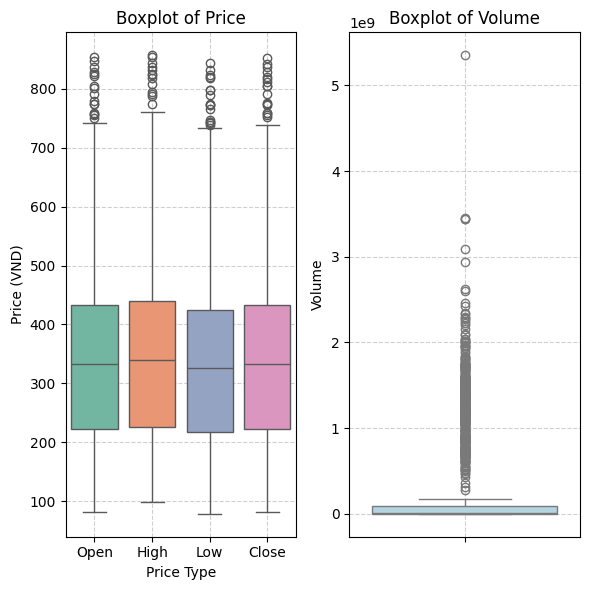

In [170]:
cols = ["Open", "High", "Low", "Close"]

data_melted = data.melt(value_vars=cols, var_name="Price Type", value_name="Price")
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.boxplot(
    x="Price Type", y="Price", data=data_melted,
    ax=axes[0], palette="Set2", order=cols
)
axes[0].set_title("Boxplot of Price")
axes[0].set_ylabel("Price (VND)")
axes[0].grid(True, linestyle="--", alpha=0.6)

sns.boxplot(
    y=data["Volume"], color="lightblue", ax=axes[1]
)
axes[1].set_title("Boxplot of Volume")
axes[1].set_xlabel("")
axes[1].set_ylabel("Volume")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()

box_path = os.path.join(FIG_DIR, "boxplot.png")
plt.savefig(box_path, dpi=150)
plt.show()
plt.close()

### 1.4.3. Histogram

Histogram is the basic chart to identify the distribution of data.

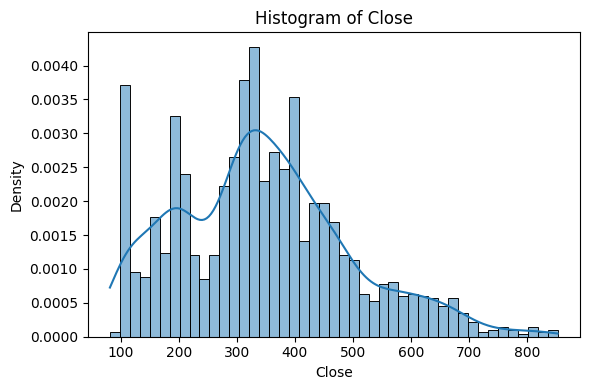

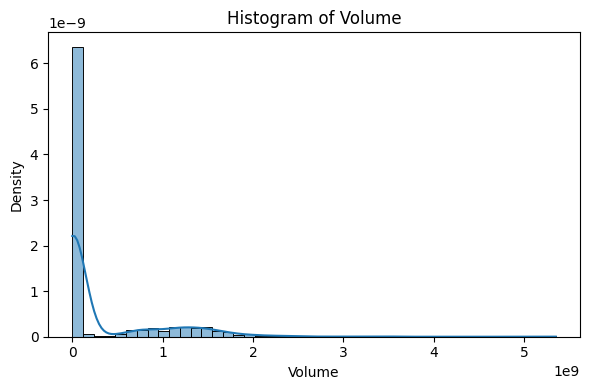

In [164]:
cols = ["Close", "Volume"]

for col in cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col].dropna(), kde=True, stat="density", bins=45)
    plt.title(f"Histogram of {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Density")
    plt.tight_layout()

    hist_path = os.path.join(FIG_DIR, f"hist_{col}.png")
    plt.savefig(hist_path, dpi=150)
    plt.show()
    plt.close()


### 1.4.4. Line Chart

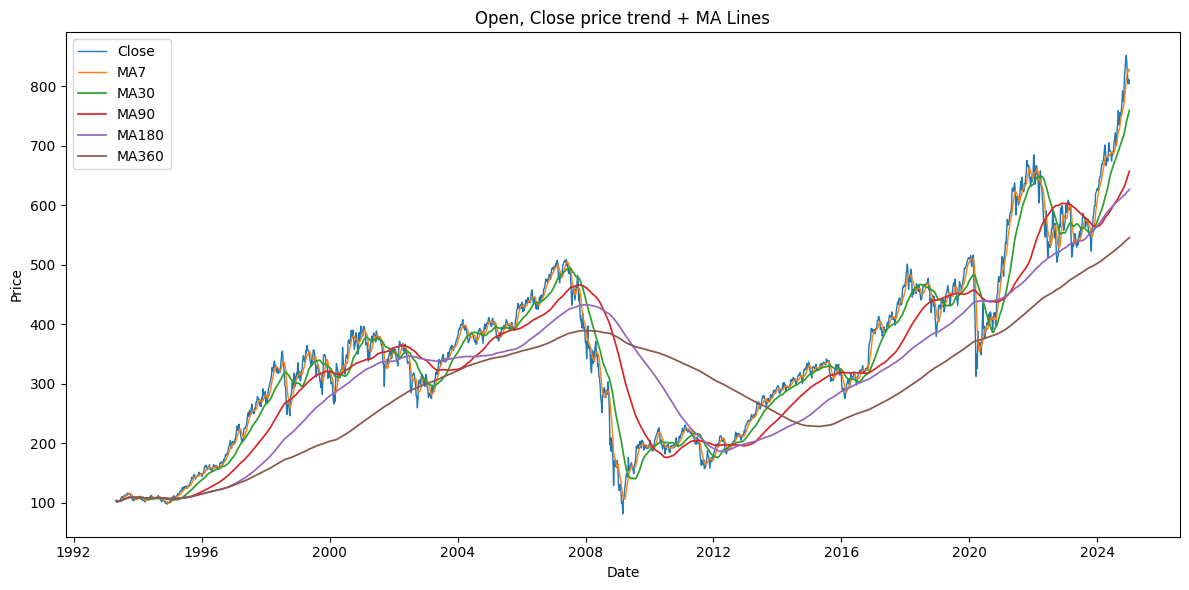

In [ ]:
df_ext = data.copy()
# df_ext = df_ext[df_ext['Date'] > "2024-01-01"]
df_ext["MA7"] = df_ext["Close"].rolling(window=7, min_periods=1).mean()
df_ext["MA30"] = df_ext["Close"].rolling(window=30, min_periods=1).mean()
df_ext["MA90"] = df_ext["Close"].rolling(window=90, min_periods=1).mean()
df_ext["MA180"] = df_ext["Close"].rolling(window=180, min_periods=1).mean()
df_ext["MA360"] = df_ext["Close"].rolling(window=360, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(df_ext["Date"], df_ext["Close"], label="Close", linewidth=1)
plt.plot(df_ext["Date"], df_ext["MA7"], label="MA7", linewidth=1)
plt.plot(df_ext["Date"], df_ext["MA30"], label="MA30", linewidth=1.25)
plt.plot(df_ext["Date"], df_ext["MA90"], label="MA90", linewidth=1.25)
plt.plot(df_ext["Date"], df_ext["MA180"], label="MA180", linewidth=1.25)
plt.plot(df_ext["Date"], df_ext["MA360"], label="MA360", linewidth=1.25)

plt.title("Open, Close price trend + MA Lines")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
line_path = os.path.join(FIG_DIR, "line_trend.png")
plt.savefig(line_path, dpi=150)
plt.close()

# Moving Average

### 1.4.5. Heatmap

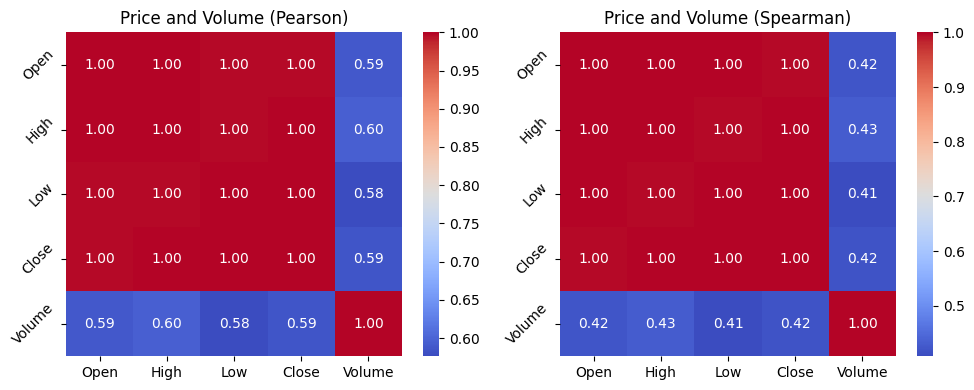

In [ ]:
corr_pear = data[["Open", "High", "Low", "Close", "Volume"]].corr(method="pearson")
corr_spear = data[["Open", "High", "Low", "Close", "Volume"]].corr(method="spearman")

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.title("Price and Volume (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(corr_spear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.title("Price and Volume (Spearman)")

plt.tight_layout()
plt.show()

# 1. tuong quan tuyen tinh [-1, 1]
# 2. tuong quan phi tuyen tinh
# 3. tuong quan da cong bien

In [169]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore

X = data[["Open", "High", "Low", "Close", "Volume"]].dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Feature          VIF
0    Open  5682.586688
1    High  7972.580946
2     Low  5292.481364
3   Close  6417.182648
4  Volume     1.815613
